In [ ]:
from __future__ import print_function
import os
import sys
import logging
import argparse
import time
from time import strftime
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import yaml
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from vgg_cifar import vgg13
import yaml
import torch
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader  # Fix added
from torchvision import datasets, transforms


In [ ]:
def test(model, device, test_loader):
    #print("In function test")

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * float(correct) / float(len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return accuracy

In [ ]:
def get_dataloaders(batch_size):
    #print("In function get_dataloaders")
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data.cifar10', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.Pad(4),
                             transforms.RandomCrop(32),
                             transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                         ])),
        batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data.cifar10', train=False, download=True,
                         transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                        ])),
        batch_size=256, shuffle=False)

    return train_loader, test_loader


In [ ]:
def read_prune_ratios_from_yaml(file_name, model):
    """
    This function reads user-defined layer-wise target pruning ratios from a YAML file.
    The ratios are stored in "prune_ratio_dict" dictionary, where the key is the layer name and
    value is the corresponding pruning ratio.

    Your task:
        Write a snippet of code to check if the layer names you provided in yaml file match the real layer name in the model.
        This can make sure your yaml file is correctly written.
    """
    #print("In function for read_prune_ratios_from_yaml")
    if not isinstance(file_name, str):
        raise Exception("filename must be a str")
    with open(file_name, "r") as stream:
        try:
            raw_dict = yaml.safe_load(stream)
            prune_ratio_dict = raw_dict['prune_ratios']

            # ===== your code starts from here ======
            # Check if the layer names in prune_ratio_dict match the model's layer names

            real_layer_names = [name for name, _ in model.named_parameters()]
            #print(real_layer_names)
            for layer_name in prune_ratio_dict:
                if layer_name not in real_layer_names:
                    raise ValueError(f"Layer name '{layer_name}' in YAML file does not match any layer in the model.")

            # ===== your code ends here ======

            return prune_ratio_dict

        except yaml.YAMLError as exc:
            print(exc)


In [ ]:


def unstructured_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    """
    Implement magnitude-based unstructured pruning for weight tensor (of a layer)
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity

    :return:
        torch.(cuda.)Tensor, pruning mask (1 for nonzeros, 0 for zeros)
    """
    #print("In function for unstructured pruning")
    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: Calculate how many weights should be pruned
    # If sparsity is 0.0, skip pruning for this layer
    if sparsity == 0.0:
        #print(f"Skipping pruning for layer with sparsity = {sparsity}")
        return torch.ones_like(tensor)
    #print("Pruning for layer")
    num_weights = tensor.numel()
    num_prune = round(num_weights * sparsity)

    # Step 2: Find the threshold of weight magnitude (th) based on sparsity.
    # Flatten tensor to 1D and get the threshold value for pruning
    flattened_tensor = tensor.abs().view(-1)
    if num_prune > 0 and num_prune <= flattened_tensor.numel():
      th = torch.kthvalue(flattened_tensor, num_prune).values.item()
    else:
      raise ValueError(f"num_prune {num_prune} is out of range for the tensor size {flattened_tensor.numel()}")

    th = torch.kthvalue(flattened_tensor, num_prune).values.item()

    # Step 3: Get the pruning mask tensor based on the threshold.
    #         |weight| <= th -> mask=0,
    #         |weight| >  th -> mask=1
    mask = (tensor.abs() > th).float()
    #print("The mask is: ", mask)
    # Step 4: Apply mask tensor to the weight tensor
    #         weight_pruned = weight * mask
    weight_pruned = tensor * mask

    ##################### YOUR CODE ENDS HERE #######################

    # Return the mask to record the pruning location
    return mask


In [ ]:
def filter_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    """
    Implement L2-norm-based filter pruning for weight tensor (of a layer)
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity

    :return:
        torch.(cuda.)Tensor, pruning mask (1 for nonzeros, 0 for zeros)
    """
    #print("In function for filter pruning")

    # If sparsity is 0, return a mask of all ones (no pruning)
    if sparsity == 0:
        return torch.ones_like(tensor)
    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: Calculate how many filters should be pruned
    num_filters = tensor.size(0)  # Number of filters in the first dimension
    num_prune = round(num_filters * sparsity)

    # Step 2: Find the threshold of filter's L2-norm (th) based on sparsity.
    # Calculate L2 norm for each filter (assume shape [num_filters, ...])
    filter_norms = tensor.view(num_filters, -1).norm(2, dim=1)
    th = torch.kthvalue(filter_norms, num_prune).values.item()

    # Step 3: Get the pruning mask tensor based on the threshold.
    #         ||filter||2 <= th -> mask=0,
    #         ||filter||2 >  th -> mask=1
    mask = (filter_norms > th).float().view(-1, *([1] * (tensor.dim() - 1)))

    # Step 4: Apply mask tensor to the weight tensor
    #         weight_pruned = weight * mask
    weight_pruned = tensor * mask
    #print("The mask is: ", mask)
    ##################### YOUR CODE ENDS HERE #######################

    # Return the mask to record the pruning location
    return mask


In [ ]:
def test_sparity(model, sparsity_type, pruning_method):
    """
    Check and print the model sparsity for each layer.
    :param model: The neural network model
    :param sparsity_type: Type of sparsity ('unstructured' or 'filter')
    """

    #print("Inside function test sparsity")

    total_zeros = 0
    total_nonzeros = 0
    total_filters = 0
    total_empty_filters = 0

    print(f"\nSparsity type: {sparsity_type}")

    for name, weight in model.named_parameters():
        if 'weight' in name:  # Only consider weight parameters
            num_elements = weight.numel()
            num_zeros = (weight == 0).sum().item()
            num_nonzeros = num_elements - num_zeros

            total_zeros += num_zeros
            total_nonzeros += num_nonzeros

            if sparsity_type == "unstructured":
                sparsity_ratio = (num_zeros / num_elements) * 100
                print(f"(zero/total) weights of {name} is: ({num_zeros}/{num_elements}). Sparsity is: {sparsity_ratio:.2f}%")

            elif sparsity_type == "filter":
                # Count filter sparsity
                num_filters = weight.size(0)
                filter_zeros = (weight.view(num_filters, -1).norm(2, dim=1) == 0).sum().item()

                total_filters += num_filters
                total_empty_filters += filter_zeros
                filter_sparsity = (filter_zeros / num_filters) * 100
                print(f"(empty/total) filters of {name} is: ({filter_zeros}/{num_filters}). Filter sparsity is: {filter_sparsity:.2f}%")

    if sparsity_type == "unstructured":
        overall_sparsity = (total_zeros / (total_zeros + total_nonzeros)) * 100
        if pruning_method =="oneshot":
                  total_sparsity_unstructured_oneshot.append(overall_sparsity)
        elif pruning_method =="iterative":
                  total_sparsity_unstructured_iterative.append(overall_sparsity)
        print(f"\nTotal zeros: {total_zeros}, non-zeros: {total_nonzeros}, overall sparsity: {overall_sparsity:.4f}%")

    elif sparsity_type == "filter":
        overall_filter_sparsity = (total_empty_filters / total_filters) * 100
        if pruning_method =="oneshot":
                  total_sparsity_filter_oneshot.append(overall_filter_sparsity)
        elif pruning_method =="iterative":
                  total_sparsity_filter_iterative.append(overall_filter_sparsity)

        print(f"\nTotal empty filters: {total_empty_filters}, total filters: {total_filters}, overall filter sparsity: {overall_filter_sparsity:.4f}%")


In [ ]:
def masked_retrain(model, train_loader, optimizer, criterion, num_epochs):
    """
    Fine-tune the pruned model while keeping pruned weights at zero, with a learning rate scheduler.
    :param model: The pruned neural network model
    :param train_loader: DataLoader for training data
    :param optimizer: Optimizer used for retraining
    :param criterion: Loss function
    :param num_epochs: Number of training epochs
    """
    #print("Inside function masked retrain")

    # Create a mask for each layer based on current zero weights
    masks = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            masks[name] = (param != 0).float()  # Mask with 1s for non-zero weights, 0s for pruned weights



         # Learning rate scheduler for fine-tuning
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader), eta_min=4e-08)

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # Track loss for the epoch
        for data, target in train_loader:
            data, target = data.to(next(model.parameters()).device), target.to(next(model.parameters()).device)

            # Forward pass
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Reapply pruning mask to keep pruned weights at zero
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        param.mul_(masks[name])  # Apply the mask to keep pruned weights at zero

            # Accumulate loss for reporting
            epoch_loss += loss.item()

        # Step the scheduler after every epoch
        scheduler.step()

        # Report loss and current learning rate
        current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, LR: {current_lr:.8f}")

    print("Masked retraining complete.")


In [ ]:
def oneshot_magnitude_prune(model, sparsity_type, prune_ratio_dict, train_loader, optimizer, criterion, num_epochs, pruning_method):
    """
    Conduct one-shot magnitude-based pruning for each layer in the model.
    :param model: The neural network model to be pruned
    :param sparsity_type: Type of sparsity ('unstructured' or 'filter')
    :param prune_ratio_dict: Dictionary containing layer-wise sparsity ratios
    :param train_loader: DataLoader for training data
    :param optimizer: Optimizer used for retraining
    :param criterion: Loss function
    :param num_epochs: Number of epochs for masked retraining
    """
    #print("Inside the function: One shot pruning")
    # Apply pruning based on prune_ratio_dict
    for name, param in model.named_parameters():
        if 'weight' in name:
            # Get the layer-wise prune ratio from the dictionary
            prune_ratio = prune_ratio_dict.get(name, 0)
            # print("tensor before pruning: {param}")
            # Apply unstructured or filter pruning
            if sparsity_type == 'unstructured':
                mask = unstructured_prune(param, prune_ratio)
                if name == "features.3.weight":
                  sparsity_mask_unstructured_oneshot.append(mask)
            elif sparsity_type == 'filter':
                mask = filter_prune(param, prune_ratio)
                if name == "features.3.weight":
                  sparsity_mask_filter_oneshot.append(mask)
            else:
                raise ValueError("Unknown sparsity type. Choose 'unstructured' or 'filter'.")

            # Apply mask to the weight parameter to set pruned weights to zero
            param.data.mul_(mask)
            #print("tensor after pruning with mask- {mask} : ", param)
    # Fine-tune (masked retraining) the pruned model to restore accuracy
    masked_retrain(model, train_loader, optimizer, criterion, num_epochs)


In [ ]:
def iterative_magnitude_prune(model, sparsity_type, prune_ratio_dict, train_loader, optimizer, criterion, num_epochs, num_iterations=3):
    """
    Conduct iterative magnitude-based pruning for each layer in the model.
    :param model: The neural network model to be pruned
    :param sparsity_type: Type of sparsity ('unstructured' or 'filter')
    :param prune_ratio_dict: Dictionary containing target layer-wise sparsity ratios
    :param train_loader: DataLoader for training data
    :param optimizer: Optimizer used for retraining
    :param criterion: Loss function
    :param num_epochs: Number of epochs for masked retraining at each pruning level
    :param num_iterations: Number of pruning and retraining iterations
    """
    #print("Inside the function: Iterative pruning")

    # Iterate through pruning levels
    for iteration in range(num_iterations):
        print(f"\nIteration {iteration + 1}/{num_iterations}")

        # Calculate current pruning ratio for each layer based on target sparsity
        current_prune_ratios = {}
        for layer_name, target_sparsity in prune_ratio_dict.items():
            current_prune_ratios[layer_name] = target_sparsity * ((iteration + 1) / num_iterations)

        print("Prune ratios for layers in this iteration are: {current_prune_ratios}")
        # Apply pruning based on current prune ratios
        for name, param in model.named_parameters():
            if 'weight' in name:
                # Get the current layer's prune ratio
                prune_ratio = current_prune_ratios.get(name, 0)

                # Apply either unstructured or filter pruning
                if sparsity_type == 'unstructured':
                    mask = unstructured_prune(param, prune_ratio)
                    if name == "features.3.weight":
                      sparsity_mask_unstructured_iterative.append(mask)
                elif sparsity_type == 'filter':
                    mask = filter_prune(param, prune_ratio)
                    if name == "features.3.weight":
                      sparsity_mask_filter_iterative.append(mask)
                else:
                    raise ValueError("Unknown sparsity type. Choose 'unstructured' or 'filter'.")

                # Apply mask to the weight parameter
                param.data.mul_(mask)

        # Retrain (masked retraining) the pruned model to restore accuracy
        print("Starting masked retraining...")
        masked_retrain(model, train_loader, optimizer, criterion, num_epochs)
        print("Retraining complete for this iteration.")

    print("Iterative magnitude pruning complete.")


In [ ]:
def find_next_conv_layer(model, current_layer_name):
    """
    Finds the next convolutional layer in the model after the given layer.

    Args:
        model: The model to search through.
        current_layer_name: The name of the current layer.

    Returns:
        Name of the next convolutional layer or None if no more layers exist.
    """
    found_current = False
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            if found_current:
                return name
            if name == current_layer_name:
                found_current = True
    return None


In [ ]:
def prune_channels_after_filter_prune(pruned_model, prune_ratios):
    """
    Prunes channels in the next convolutional layer based on pruned filters
    from the current convolutional layer.

    Args:
        pruned_model: Model already pruned at filter level.
        prune_ratios: Dictionary of pruning ratios for layers.
    """
    for name, module in pruned_model.named_modules():
        if isinstance(module, nn.Conv2d) and name in prune_ratios:
            # Get the filter weights and pruning ratio for this layer
            filter_weights = module.weight.data
            prune_ratio = prune_ratios[name]

            # Find pruned filters (all-zero filters)
            pruned_filters = torch.all(filter_weights == 0, dim=(1, 2, 3))
            pruned_indices = torch.nonzero(pruned_filters).squeeze()

            if pruned_indices.nelement() > 0:
                # Locate the next convolutional layer
                next_layer_name = find_next_conv_layer(pruned_model, name)

                if next_layer_name is not None:
                    next_3layer = dict(pruned_model.named_modules())[next_layer_name]
                    next_layer_param = next_layer.weight

                    if next_layer_param.dim() == 4:
                        # Zero out the channels corresponding to pruned filters
                        next_layer_param.data[:, pruned_indices, :, :] = 0
                        print(f"Pruned channels in {next_layer_name} corresponding to pruned filters in {name}.")
                    elif next_layer_param.dim() == 2:
                        # Fully connected layers: zero out corresponding weights
                        next_layer_param.data[:, pruned_indices] = 0
                        print(f"Pruned input neurons in {next_layer_name} corresponding to pruned filters in {name}.")
                    else:
                        print(f"Skipping {next_layer_name} (unexpected dimension: {next_layer_param.dim()}).")

    return pruned_model




In [ ]:
# Define the test function
def test_accuracy(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = 100.0 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
def function(epochs, batch_size, seed, load_model_path, sparsity_type, pruning_method, yaml_path, apply_channel_pruning, file_path):
    #print("In main")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Setup random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set up model architecture and load pretrained dense model
    model = vgg13()
    model.load_state_dict(torch.load(load_model_path, map_location=device))
    #model.load_state_dict(torch.load(load_model_path))
    model = model.to(device)
    if use_cuda:
        model.cuda()
    # Prepare the test dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 normalization
    ])
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    # Evaluate the model
    accuracy = test_accuracy(model, device, test_loader)
    print(f"Test Accuracy of the original pretrained model: {accuracy:.2f}%")
    print(file_path)
    # Prepare data loaders
    train_loader, test_loader = get_dataloaders(batch_size)


    # Read prune ratios from YAML file
    if(sparsity_type == "unstructured"):
        yaml_path = "vgg13_example.yaml"
    elif(sparsity_type == "filter"):
        yaml_path = "vgg13_filter.yaml"
    prune_ratio_dict = read_prune_ratios_from_yaml(yaml_path, model)

    # Select loss function
    criterion = nn.CrossEntropyLoss()

    # Select optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

    # Learning rate scheduler for fine-tuning
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader), eta_min=4e-08)

    # Step 1: Apply pruning (one-shot or iterative)
    if pruning_method == 'oneshot':
        oneshot_magnitude_prune(model, sparsity_type, prune_ratio_dict, train_loader, optimizer, criterion, epochs, pruning_method)
    elif pruning_method == 'iterative':
        iterative_magnitude_prune(model, sparsity_type, prune_ratio_dict, train_loader, optimizer, criterion, epochs, num_iterations=3)

    # Step 2: Fine-tune the pruned model with masked retraining
    #masked_retrain(model, train_loader, optimizer, criterion, epochs)

    # Step 3: Apply pruning of channels after filter pruning (if needed)
    if sparsity_type == 'filter' and apply_channel_pruning == True:
        model = prune_channels_after_filter_prune(model, prune_ratio_dict)

    # Step 4: Test the model and check sparsity
    print("\nTesting Model after Pruning and Retraining...")
    test_sparity(model, sparsity_type, pruning_method)
    accuracy= test(model, device, test_loader)
    if sparsity_type == "unstructured":
        if pruning_method =="oneshot":
                  accuracy_unstructured_oneshot.append(accuracy)
        elif pruning_method =="iterative":
                  accuracy_unstructured_iterative.append(accuracy)
    elif sparsity_type == "filter":
        if pruning_method =="oneshot":
                  accuracy_filter_oneshot.append(accuracy)
        elif pruning_method =="iterative":
                  accuracy_filter_iterative.append(accuracy)
    print(f"Saving pruned model to {file_path}")
    torch.save(model.state_dict(), file_path)


In [ ]:
sparsity_mask_unstructured_oneshot=[]
sparsity_mask_filter_oneshot=[]
sparsity_mask_unstructured_iterative=[]
sparsity_mask_filter_iterative=[]

accuracy_unstructured_oneshot=[]
accuracy_filter_oneshot=[]
accuracy_unstructured_iterative=[]
accuracy_filter_iterative=[]

total_sparsity_unstructured_oneshot=[]
total_sparsity_filter_oneshot=[]
total_sparsity_unstructured_iterative=[]
total_sparsity_filter_iterative=[]

accuracy=[]
sparsity=[]

In [ ]:
def main():
  print("This program will prune a pre-trained VGG13 model and save the fine-tuned models for Pruning methods: ITERATIVE AND ONESHOT and SPARSITY TYPE=UNSTRUCTURED AND FILTER. PRUNING THE MODELS MIGHT TAKE TIME AS FINE-TUNING WOULD TAKE TIME. BY THE END OF THE EXECUTION, ALL THE FOUR PRUNED MODELS WILL BE SAVED")
  #FILTER ONESHOT
  print("FILTER ONESHOT")
  epochs=10
  batch_size = 64
  seed=1
  load_model_path="cifar10_vgg13_acc_94.730.pt"
  sparsity_type="filter"
  pruning_method="oneshot"
  yaml_path="vgg13_example.yaml"
  apply_channel_pruning=True
  file_path="FILTER_ONESHOT.pt"
  function(epochs, batch_size, seed, load_model_path, sparsity_type, pruning_method, yaml_path, apply_channel_pruning, file_path)
  #FILTER ITERATIVE
  print("FILTER ITERATIVE")
  epochs=10
  batch_size = 64
  seed=1
  load_model_path="cifar10_vgg13_acc_94.730.pt"
  sparsity_type="filter"
  pruning_method="iterative"
  yaml_path="vgg13_example.yaml"
  apply_channel_pruning=True
  file_path="FILTER_ITERATIVE.pt"
  function(epochs, batch_size, seed, load_model_path, sparsity_type, pruning_method, yaml_path, apply_channel_pruning, file_path)

  #UNSTRUCTURED ONESHOT
  print("UNSTRUCTURED ONESHOT")
  epochs=10
  batch_size = 64
  seed=1
  load_model_path="cifar10_vgg13_acc_94.730.pt"
  sparsity_type="unstructured"
  pruning_method="oneshot"
  yaml_path="vgg13_example.yaml"
  apply_channel_pruning=True
  file_path="UNSTRUCTURED_ONESHOT.pt"
  function(epochs, batch_size, seed, load_model_path, sparsity_type, pruning_method, yaml_path, apply_channel_pruning, file_path)

  #UNSTRUCTURED ITERATIVE
  print("UNSTRUCTURED ITERATIVE")
  epochs=10
  batch_size = 64
  seed=1
  load_model_path="cifar10_vgg13_acc_94.730.pt"
  sparsity_type="unstructured"
  pruning_method="iterative"
  yaml_path="vgg13_example.yaml"
  apply_channel_pruning=True
  file_path="UNSTRUCTURED_ITERATIVE.pt"
  function(epochs, batch_size, seed, load_model_path, sparsity_type, pruning_method, yaml_path, apply_channel_pruning, file_path)
  sparsity_mask_unstructured_iterative= sparsity_mask_unstructured_iterative[-1]
  sparsity_mask_filter_iterative=sparsity_mask_filter_iterative[-1]
  sparsity_mask_filter_oneshot=sparsity_mask_filter_oneshot[-1]
  sparsity_mask_unstructured_oneshot=sparsity_mask_unstructured_oneshot[-1]

  accuracy.append(accuracy_unstructured_oneshot[-1])
  accuracy.append(accuracy_filter_oneshot[-1])
  accuracy.append(accuracy_unstructured_iterative[-1])
  accuracy.append(accuracy_filter_iterative[-1])
  sparsity.append(total_sparsity_unstructured_oneshot[-1])
  sparsity.append(total_sparsity_filter_oneshot[-1])
  sparsity.append(total_sparsity_unstructured_iterative[-1])
  sparsity.append(total_sparsity_filter_iterative[-1])
    # Plot sparsity masks for each model
  plot_sparsity_mask(sparsity_mask_unstructured_iterative, 'IMP Unstructured')
  plot_sparsity_mask(sparsity_mask_filter_oneshot, 'OMP Filter')
  plot_sparsity_mask(sparsity_mask_unstructured_oneshot, 'OMP Unstructured')
  plot_sparsity_mask(sparsity_mask_filter_iterative, 'IMP Filter')
  plot_accuracy1(sparsity, accuracy)
  plot_accuracy2(sparsity, accuracy)

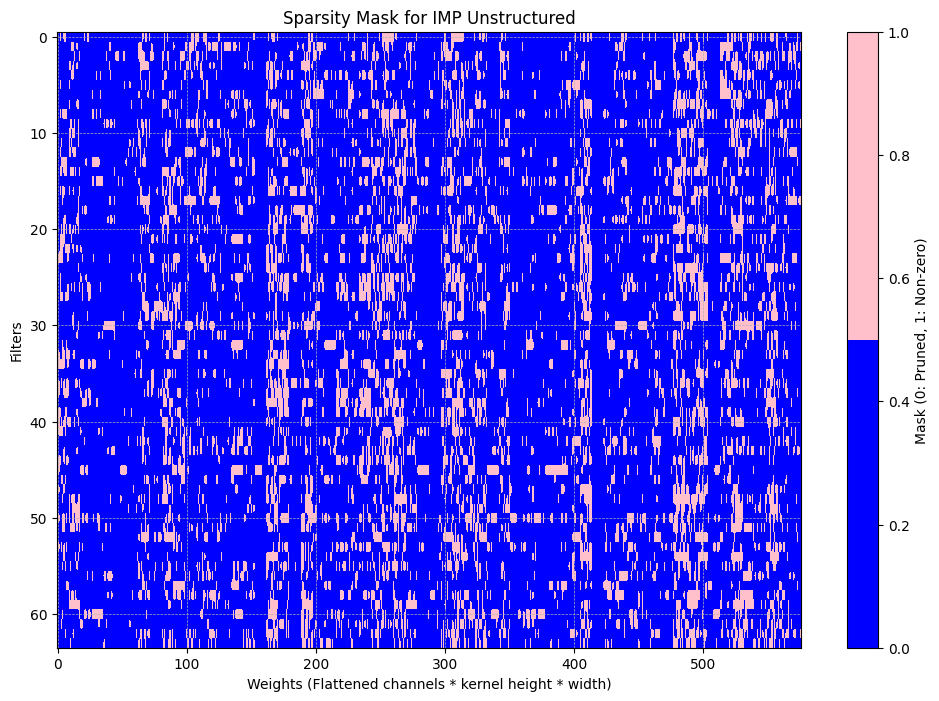

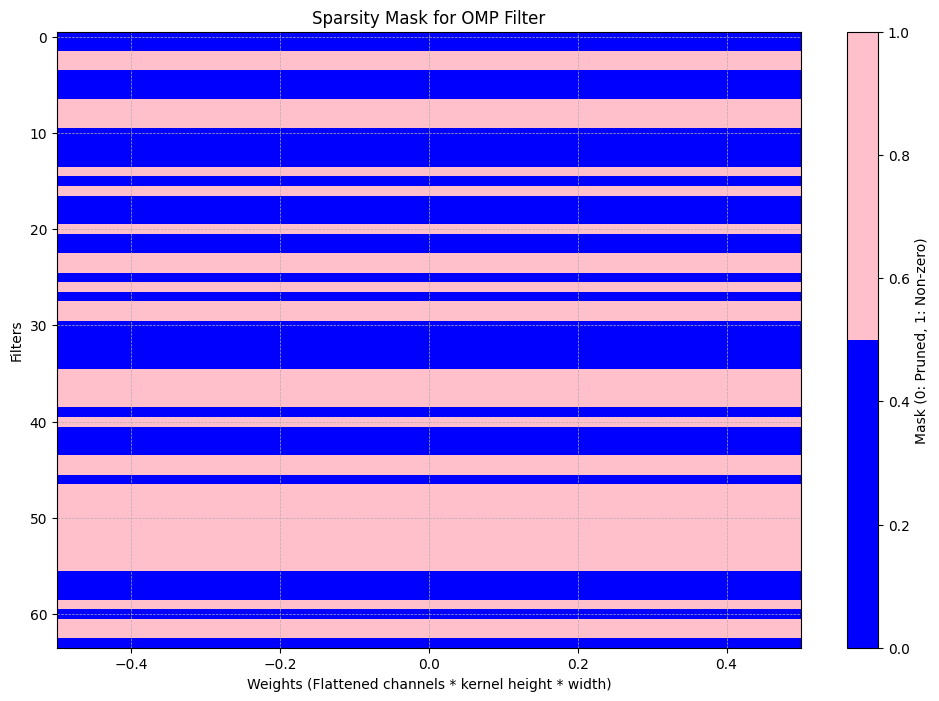

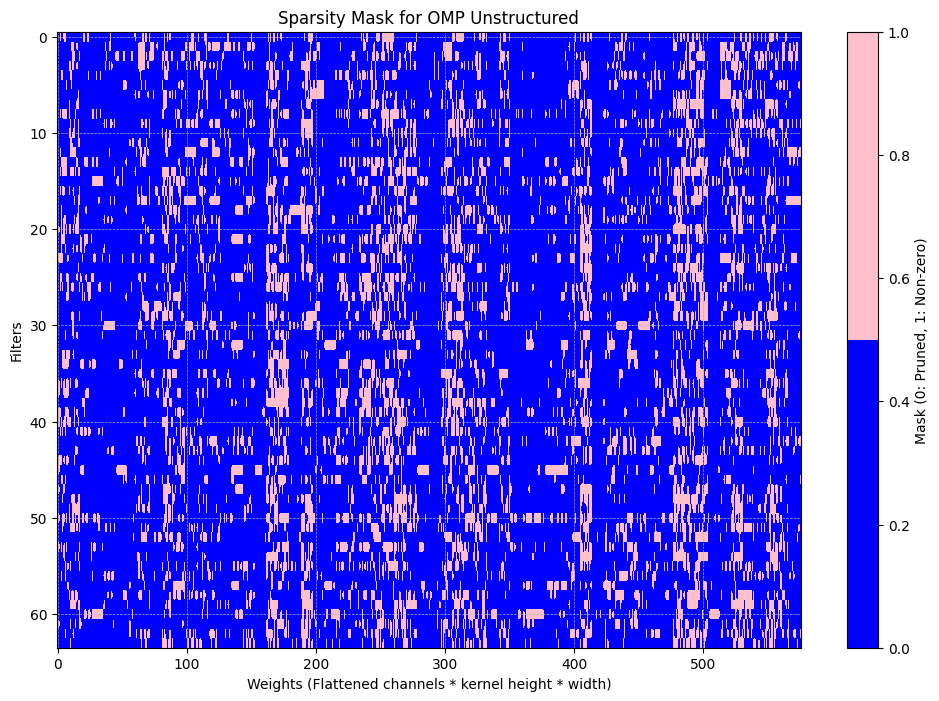

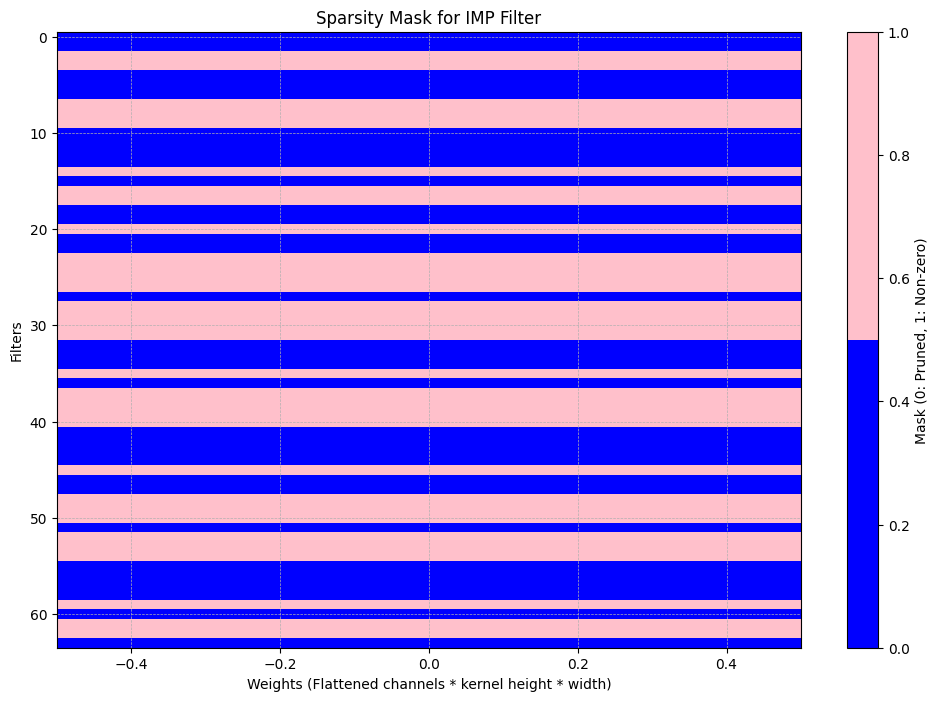

In [ ]:
# Function to plot the sparsity mask for one model (binary mask)
def plot_sparsity_mask(sparsity_mask, model_name):
    # Move tensor to CPU if it's on GPU
    sparsity_mask = sparsity_mask.cpu()

    # Reshape the 4D mask (num_filters, num_channels, kernel_height, kernel_width)
    num_filters, num_channels, kernel_height, kernel_width = sparsity_mask.shape
    reshaped_mask = sparsity_mask.reshape(num_filters, num_channels * kernel_height * kernel_width)

    # Create a binary mask where 0 is pruned (zero) and 1 is kept (non-zero)
    binary_mask = (reshaped_mask != 0).int()

    # Define a custom colormap (blue for pruned weights, pink for non-zero weights)
    colors = ['blue', 'pink']  # blue for pruned, pink for non-zero
    cmap = ListedColormap(colors)

    # Plot the mask with custom color
    plt.figure(figsize=(12, 8))
    plt.imshow(binary_mask, cmap=cmap, aspect='auto', vmin=0, vmax=1)
    plt.title(f'Sparsity Mask for {model_name}')
    plt.xlabel('Weights (Flattened channels * kernel height * width)')
    plt.ylabel('Filters')
    plt.colorbar(label='Mask (0: Pruned, 1: Non-zero)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()






In [ ]:
#print(len(sparsity_mask_unstructured_oneshot))

1


[91.89]
[88.88, 87.92, 87.45, 78.86]
[92.34]
[81.99]


In [ ]:
#print(accuracy)

[91.89, 78.86, 92.34, 81.99]


In [ ]:
#print(sparsity)

[79.91675338189386, 39.623601220752796, 79.91675338189386, 39.623601220752796]


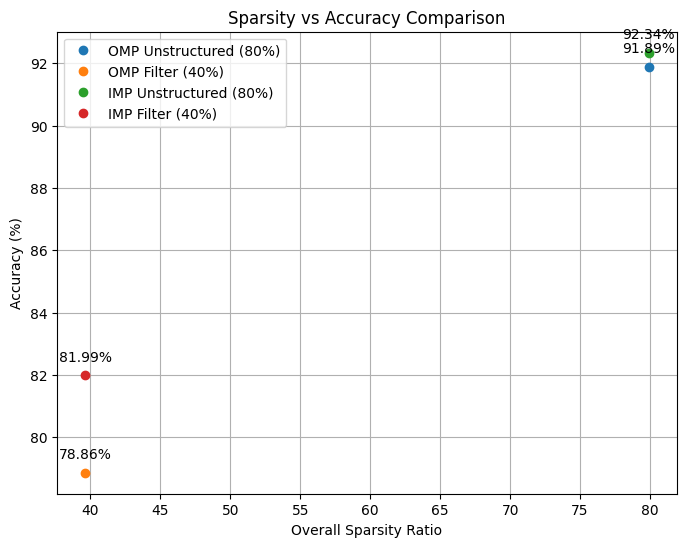

In [ ]:
def plot_accuracy1(sparsity, accuracy):
  # Model labels for the legend
  labels = [
      "OMP Unstructured (80%)",
      "OMP Filter (40%)",
      "IMP Unstructured (80%)",
      "IMP Filter (40%)"
  ]

  # Create a single figure to compare all models
  plt.figure(figsize=(8, 6))

  # Plot each model's sparsity vs accuracy
  for i in range(4):
      plt.plot(sparsity[i], accuracy[i], 'o', label=labels[i])  # Plot each model's sparsity vs accuracy

      # Annotate the point with the model label
      plt.annotate(f'{accuracy[i]:.2f}%', (sparsity[i], accuracy[i]), textcoords="offset points", xytext=(0, 10), ha='center')

  # Set labels and title
  plt.xlabel('Overall Sparsity Ratio')
  plt.ylabel('Accuracy (%)')
  plt.title('Sparsity vs Accuracy Comparison')

  # Add grid for better readability
  plt.grid(True)

  # Add a legend to label each model
  plt.legend()

  # Show the plot
  plt.show()


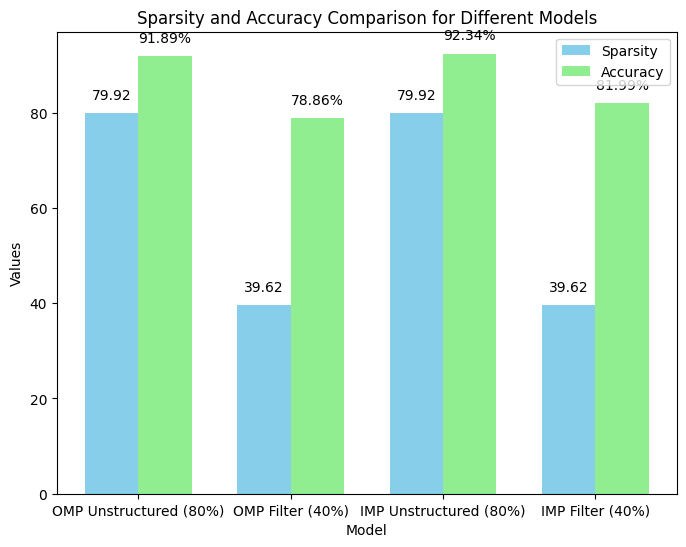

In [ ]:
def plot_accuracy2(sparsity, accuracy):
  #
  # Model labels for the legend
  labels = [
      "OMP Unstructured (80%)",
      "OMP Filter (40%)",
      "IMP Unstructured (80%)",
      "IMP Filter (40%)"
  ]



  # Define the positions for the bars
  x = np.arange(len(labels))

  # Create a single figure for the bar plot
  fig, ax = plt.subplots(figsize=(8, 6))

  # Plot the bars for sparsity and accuracy
  width = 0.35
  ax.bar(x - width/2, sparsity, width, label='Sparsity', color='skyblue')
  ax.bar(x + width/2, accuracy, width, label='Accuracy', color='lightgreen')

  # Annotate bars with values
  for i in range(len(labels)):
      ax.annotate(f'{sparsity[i]:.2f}', (x[i] - width/2, sparsity[i]), textcoords="offset points", xytext=(0, 10), ha='center')
      ax.annotate(f'{accuracy[i]:.2f}%', (x[i] + width/2, accuracy[i]), textcoords="offset points", xytext=(0, 10), ha='center')

  # Set labels and title
  ax.set_xlabel('Model')
  ax.set_ylabel('Values')
  ax.set_title('Sparsity and Accuracy Comparison for Different Models')

  # Set the x-axis tick labels
  ax.set_xticks(x)
  ax.set_xticklabels(labels)

  # Add a legend to label each model
  ax.legend()

  # Show the plot
  plt.show()
